<a href="https://colab.research.google.com/github/TruongCaoThanhNhat/project-mayhoc/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chuẩn bị dữ liệu

## Cấu hình cho kaggle

In [ ]:
# Cài đặt Kaggle API
# !pip install kaggle

# Upload kaggle.json
from google.colab import files
files.upload()
# Cấu hình Kaggle API key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## Tải dataset từ Kaggle

In [ ]:
# Tải dataset từ Kaggle
!kaggle datasets download -d phamtheds/news-dataset-vietnameses

# Giải nén tập tin zip
!unzip news-dataset-vietnameses.zip -d /content/input


Dataset URL: https://www.kaggle.com/datasets/phamtheds/news-dataset-vietnameses
License(s): copyright-authors
 98% 303M/308M [00:03<00:00, 93.2MB/s]
100% 308M/308M [00:03<00:00, 102MB/s] 
Archive:  news-dataset-vietnameses.zip
  inflating: /content/input/Dataset_articles_NoID.csv  


In [ ]:
# import os
# os.kill(os.getpid(), 9)

## Import thư viện

In [ ]:
# Library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# tien xu ly van ban
!pip install pyvi
import unicodedata
from pyvi import ViTokenizer
import re
from pyvi.ViPosTagger import postagging


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics as m
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

!pip install scikeras
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.constraints import max_norm
from keras.optimizers import SGD
from prettytable import PrettyTable

## Lấy dữ liệu

In [ ]:
# Liệt kê nội dung thư mục hiện tại
print(os.listdir("."))

# Đọc dữ liệu từ file CSV
data = pd.read_csv("/content/input/Dataset_articles_NoID.csv",nrows=20000)

# Lấy mẫu ngẫu nhiên gồm 20,000 dòng
# data = dataset.sample(n=20000, random_state=1)

# Các danh mục cố định
categories_of_interest = ['Xã hội', 'Thế giới','Kinh doanh','Pháp luật','Công đoàn', 'Thời sự', 'Bất động sản','Lưu trữ']

# Lọc dữ liệu chỉ từ các danh mục cố định
filtered_data = data[data['Category'].isin(categories_of_interest)]

# In ra số lượng mẫu từ các danh mục cố định
print("Số lượng mẫu từ các danh mục cố định:", len(filtered_data))

data = filtered_data
data.head(10)


['.config', 'input', 'kaggle.json', 'news-dataset-vietnameses.zip', 'sample_data']
Số lượng mẫu từ các danh mục cố định: 19868


,URL,Title,Summary,Contents,Date,Author(s),Category,Tags
0,https://laodong.vn/bat-dong-san/thong-tin-ngoc...,"Thông tin “Ngọc Trinh mua đất ở Bảo Lộc"" chỉ l...","Lâm Đồng - Lãnh đạo thành phố Bảo Lộc, Lâm Đồn...","Những ngày vừa qua, trên trang Facebook chính ...","Thứ sáu, 20/05/2022 08:56 (GMT+7)",Phương Nhiên,Bất động sản,"['Lâm Đồng', 'Ngọc Trinh', 'Chiêu trò', 'Giá đ..."
1,https://laodong.vn/bat-dong-san/lo-hong-trong-...,Lỗ hổng trong việc thẩm tra năng lực tài chính...,TPHCM - Việc không thể cưỡng chế thuế của hai ...,"Theo thông tin từ Cục Thuế TP.HCM, hiện cơ qua...","Thứ sáu, 20/05/2022 08:10 (GMT+7)",Gia Miêu,Bất động sản,"['Thủ Thiêm', 'Đấu giá đất']"
2,https://laodong.vn/bat-dong-san/som-hoan-thien...,Sớm hoàn thiện các dự án nhà ở xã hội để CNLĐ ...,"Hiện trên địa bàn tỉnh Ninh Bình có 32 khu, cụ...",CNLĐ mong muốn sớm được tiếp cận với nhà ở xã ...,"Thứ sáu, 20/05/2022 07:47 (GMT+7)",NGUYỄN TRƯỜNG,Bất động sản,"['Dự án', 'Nhà ở xã hội', 'Dự án nhà ở xã hội'..."
3,https://laodong.vn/bat-dong-san/chi-tiet-ho-so...,Chi tiết hồ sơ hoàn công nhà ở năm 2022,Hoàn công nhà ở với ý nghĩa là điều kiện để đư...,Hoàn công nhà ở là một thủ tục hành chính tron...,"Thứ sáu, 20/05/2022 06:44 (GMT+7)",Kim Nhung (T/H),Bất động sản,"['Giấy phép xây dựng', 'Hồ sơ hoàn công', 'nhà..."
4,https://laodong.vn/bat-dong-san/khoi-tao-khong...,"Khởi tạo không gian sống đẳng cấp, đón sóng đầ...",Có rất nhiều lý do khiến những dự án thấp nội ...,Đi dọc đường Lê Văn Lương kéo dài xuống khu Dư...,"Thứ năm, 19/05/2022 15:30 (GMT+7)",Huyền Nguyễn,Bất động sản,['An Quý Villa']
5,https://laodong.vn/bat-dong-san/can-canh-khu-d...,"Cận cảnh Khu đô thị Thanh Hà bất ngờ bị ""cò"" đ...",Khu đô thị Thanh Hà Cienco 5 (thuộc quận Hà Đô...,"Những ngày qua, đất khu đô thị Thanh Hà Cienco...","Thứ năm, 19/05/2022 14:21 (GMT+7)",CAO NGUYÊN,Bất động sản,"['Khu đô thị', 'Xây dựng', 'Khu đô thị Thanh ..."
6,https://laodong.vn/quy-hoach/tiep-tuc-cuong-ch...,Tiếp tục cưỡng chế 15 biệt thự Ocean View Nha ...,"Khánh Hòa - Bên cạnh việc tổ chức cưỡng chế, c...","Ngày 19.5, UBND phường Vĩnh Trường cho biết, v...","Thứ năm, 19/05/2022 09:27 (GMT+7)",Hữu Long,Bất động sản,"['Khánh Hòa', 'Nha Trang', 'Ocean View Nha Tra..."
7,https://laodong.vn/bat-dong-san/nguyen-tac-thi...,Nguyên tắc thiết kế nhà ở công vụ,Dưới đây là nguyên tắc thiết kế nhà ở công vụ ...,Nhà ở công vụ là loại hình nhà ở được xây dựng...,"Thứ năm, 19/05/2022 08:26 (GMT+7)",Kim Nhung (T/H),Bất động sản,"['Nhà công vụ', 'Nhà ở công vụ', 'nhà ở', 'Thi..."
8,https://laodong.vn/bat-dong-san/thanh-hoa-dung...,Thanh Hoá: Dừng đột ngột phiên đấu giá dự án t...,Thanh Hoá - Dự án Trường tiểu học và THCS dân ...,"Từ ""rút ống thở"" nửa chừng… Ngày 17.5.2004, UB...","Thứ tư, 18/05/2022 18:28 (GMT+7)",Xuân Hùng,Bất động sản,"['Đất vàng', 'Thanh Hoá', 'Cty Tây Đô', 'Dự á..."
9,https://laodong.vn/nha-dep/kinh-nghiem-thue-vi...,"Kinh nghiệm thuê villa, homestay chất lượng kh...","Chuyến du lịch sắp tới, bạn đang phân vân giữa...",Villa là gì? Villa hay được gọi là biệt thự là...,"Thứ tư, 18/05/2022 16:30 (GMT+7)",Minh Huy (T/H),Bất động sản,"['Du lịch', 'Tiết kiệm chi phí', 'Nghỉ dưỡng',..."


Category
Thời sự         12833
Bất động sản     6203
Kinh doanh        361
Xã hội            163
Thế giới          105
Công đoàn          82
Lưu trữ            76
Pháp luật          45
Name: count, dtype: int64


<ipython-input-4-0c4f2e3ce8e6>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


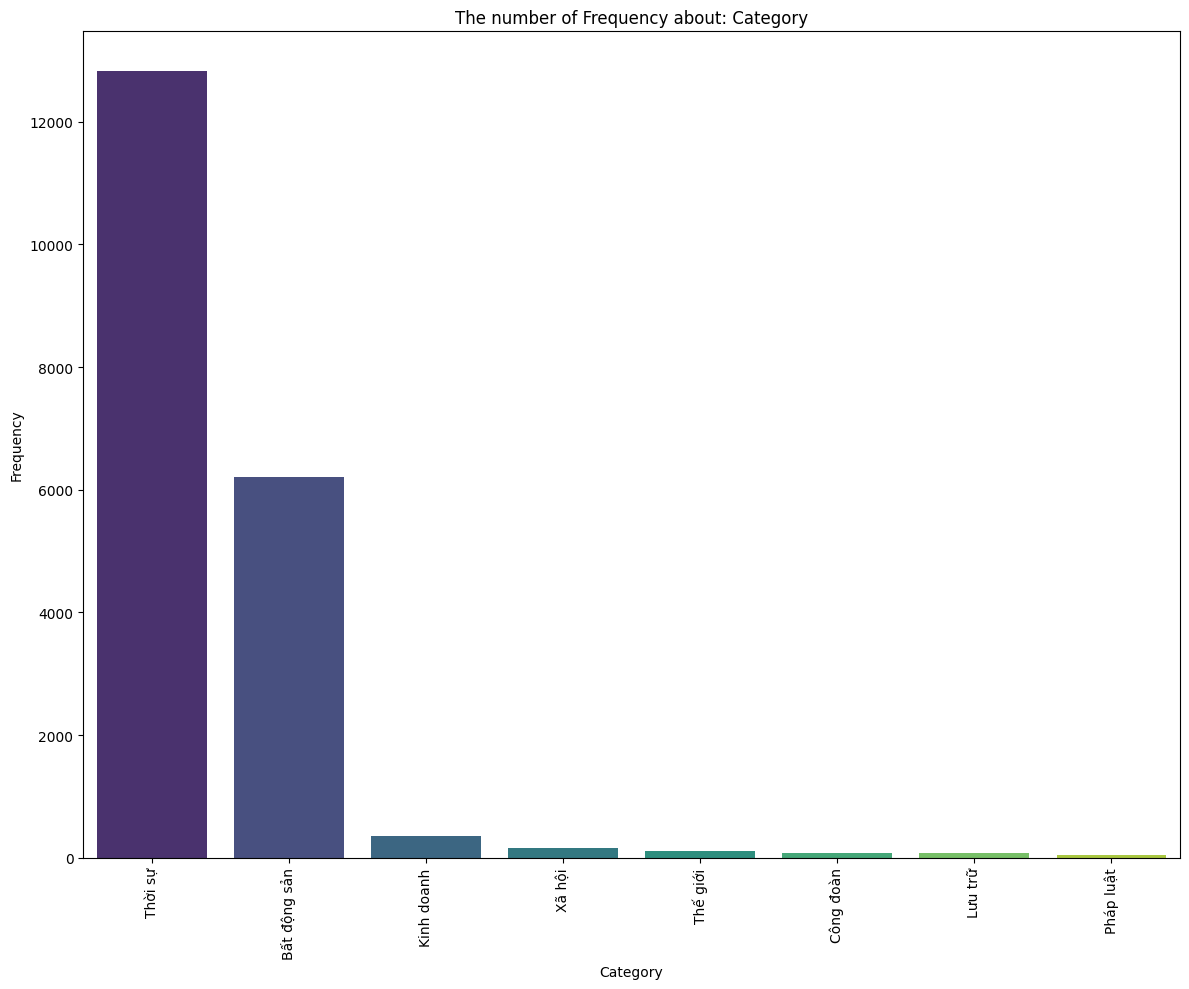

In [ ]:
column = 'Category'
# Nhóm và đếm số lượng mỗi danh mục
category_counts = data['Category'].value_counts()
print(category_counts)

plt.figure(figsize=(12, 10))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.title(f"The number of Frequency about: {column}")
plt.xticks(rotation=90,fontsize = 10)
plt.tight_layout()
plt.show()

 # Xử lý dữ liệu

## Xử lý dữ liệu bị thiếu

Tổng số dữ liệu thiếu trong mỗi cột:
URL            0
Title          0
Summary        3
Contents     349
Date           0
Author(s)    155
Category       0
Tags           0
dtype: int64

Tỷ lệ dữ liệu thiếu trong mỗi cột:
URL          0.000000
Title        0.000000
Summary      0.015100
Contents     1.756594
Date         0.000000
Author(s)    0.780149
Category     0.000000
Tags         0.000000
dtype: float64


<ipython-input-5-53bc5557c8c5>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_data.index, y=missing_data.values, palette="viridis")


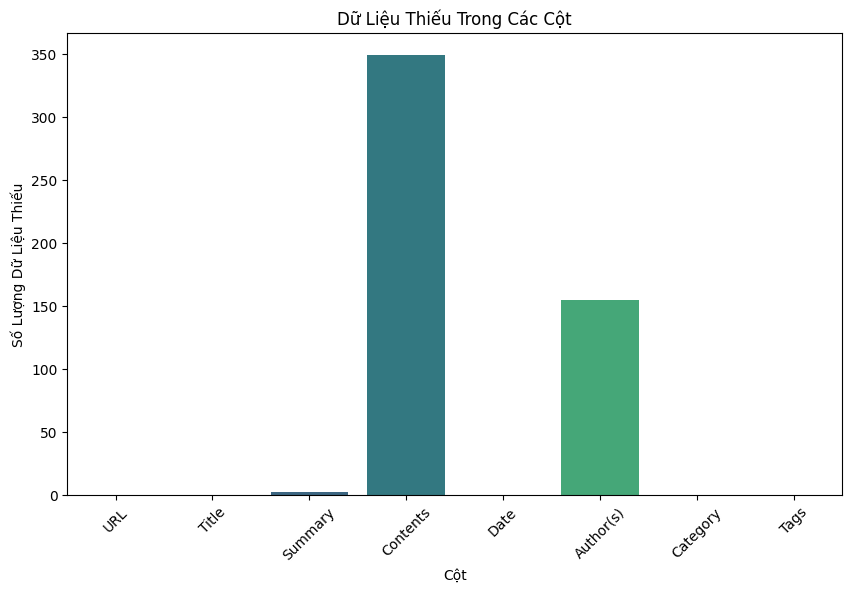

In [ ]:
# Kiểm tra tổng số dữ liệu thiếu trong mỗi cột
missing_data = data.isnull().sum()
print("Tổng số dữ liệu thiếu trong mỗi cột:")
print(missing_data)

# Tỷ lệ dữ liệu thiếu
missing_percentage = (data.isnull().sum() / len(data)) * 100
print("\nTỷ lệ dữ liệu thiếu trong mỗi cột:")
print(missing_percentage)

# Vẽ biểu đồ cột thể hiện dữ liệu thiếu
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_data.index, y=missing_data.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel('Cột')
plt.ylabel('Số Lượng Dữ Liệu Thiếu')
plt.title('Dữ Liệu Thiếu Trong Các Cột')
plt.show()

# Loại bỏ các dòng chứa dữ liệu thiếu
data.dropna(inplace=True)


## Tiền xử lý dữ liệu

In [ ]:
# Danh sách các stop words
stop_words = set([
    "là", "của", "và", "cho", "trong", "các", "với", "được", "khi", "một", "hay", "để"
])

def remove_stopwords(text):
    # Tách từ với pyvi
    words, tags = postagging(ViTokenizer.tokenize(text))

    # Loại bỏ các stop words
    filtered_text = ' '.join([word for word, tag in zip(words, tags) if word.lower() not in stop_words])

    return filtered_text

# Hàm chuẩn hóa văn bản tiếng Việt
def normalize_vietnamese_text(text):
    # Chuẩn hóa unicode
    normalized_text = unicodedata.normalize('NFC', text)

    # chuyển sang chữ thường
    normalized_text = normalized_text.lower()

    # Chuẩn hóa dấu câu
    normalized_text = re.sub(r'[^\w\s]', '', normalized_text)

    # Loại bỏ khoảng trắng dư thừa
    normalized_text = re.sub(r'\s+', ' ', normalized_text).strip()

    tokens = remove_stopwords(normalized_text)

    return tokens


In [ ]:
# # Áp dụng chuẩn hóa cho từng cột dữ liệu văn bản
# for column in data.columns:
#     if data[column].dtype == 'object':  # Chỉ áp dụng cho các cột có kiểu dữ liệu là object (string)
#         data[column] = data[column].apply(normalize_vietnamese_text)

# Áp dụng tiền xử lý chỉ cho các trường nhất định
data['Summary'] = data['Summary'].apply(normalize_vietnamese_text)
data['Contents'] = data['Contents'].apply(normalize_vietnamese_text)

data.loc[:, [ 'Contents', 'Summary', 'Category']].head(10)


,Contents,Summary,Category
0,những ngày vừa_qua trên trang facebook chính c...,lâm đồng lãnh_đạo thành_phố bảo lộc lâm đồng k...,Bất động sản
1,theo thông_tin từ cục thuế tphcm hiện cơ_quan_...,tphcm việc không_thể cưỡng_chế thuế hai doanh_...,Bất động sản
2,cnlđ mong_muốn sớm tiếp_cận nhà ở xã_hội theo ...,hiện trên địa_bàn tỉnh ninh bình có 32 khu cụm...,Bất động sản
3,hoàn_công nhà ở thủ_tục hành_chính hoạt_động x...,hoàn_công nhà ở ý_nghĩa_là điều_kiện cấp đổi l...,Bất động sản
4,đi dọc đường lê văn lương kéo_dài xuống khu dư...,có rất nhiều lý_do khiến những dự_án thấp nội_...,Bất động sản
5,những ngày qua đất khu đô_thị thanh hà cienco ...,khu đô_thị thanh hà cienco 5 thuộc quận hà đôn...,Bất động sản
6,ngày 195 ubnd phường vĩnh trường biết vừa có b...,khánh hòa bên cạnh việc tổ_chức cưỡng_chế chín...,Bất động sản
7,nhà ở công_vụ loại_hình nhà ở xây_dựng trên ng...,dưới đây nguyên_tắc thiết_kế nhà ở công_vụ việ...,Bất động sản
8,từ rút ống thở nửa_chừng ngày 1752004 ubnd tỉn...,thanh hoá dự_án trường tiểu_học thcs dân_lập t...,Bất động sản
9,villa gì villa gọi biệt_thự loại_hình nhà ở có...,chuyến du_lịch sắp tới bạn đang phân_vân giữa ...,Bất động sản


## Chia tập dữ liệu
- Các đặc trưng đầu vào : Contents

In [ ]:
# Chia dữ liệu thành features (X) và labels (y)
X = data['Contents']
y = data['Category']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# In ra kích thước của từng tập dữ liệu
print("Số lượng mẫu trong tập huấn luyện:", len(X_train))
print("Số lượng mẫu trong tập kiểm tra:", len(X_test))

Số lượng mẫu trong tập huấn luyện: 15492
Số lượng mẫu trong tập kiểm tra: 3873


## Dùng TF-IDF để trích xuất đặc trưng

In [ ]:
# Vector hóa dữ liệu văn bản sử dụng TF-IDF
# vectorizer = TfidfVectorizer(max_features=100)  # Chọn số lượng đặc trưng tối đa
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# input_shape = X_train_tfidf.shape[1]
# print(f"Input shape: {input_shape}")

# Số lượng feature sau khi fit
# num_features = len(vectorizer.vocabulary_)
# print("Số lượng feature vector: ", num_features)
# Số lượng feature vector:  59866

# Huấn luyện với các mô hình

## Huấn luyện với mô hình Naive Bayes

Naive Bayes Classifier:
              precision    recall  f1-score   support

Bất động sản       0.89      0.97      0.93      1187
   Công đoàn       1.00      0.00      0.00        17
  Kinh doanh       1.00      0.00      0.00        67
     Lưu trữ       1.00      0.00      0.00        16
   Pháp luật       1.00      0.00      0.00         7
    Thế giới       1.00      0.00      0.00        30
     Thời sự       0.94      0.97      0.96      2510
      Xã hội       1.00      0.00      0.00        39

    accuracy                           0.93      3873
   macro avg       0.98      0.24      0.24      3873
weighted avg       0.93      0.93      0.91      3873

Accuracy: 0.927704621740253
Precision 0.8860040058205619
Recall 0.927704621740253
F1 0.9062801970448828


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


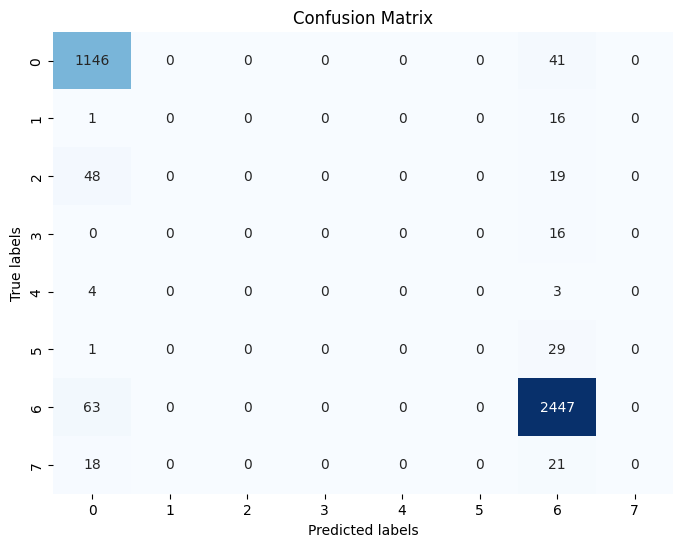

In [ ]:
# Khởi tạo và huấn luyện mô hình Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Đưa ra dự đoán trên tập kiểm tra
y_pred_nb = nb_model.predict(X_test_tfidf)

# Đánh giá mô hình
print("Naive Bayes Classifier:")
print(classification_report(y_test, y_pred_nb,zero_division=1))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision",precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall",recall_score(y_test, y_pred_nb, average='weighted'))
print("F1",f1_score(y_test, y_pred_nb, average='weighted'))


cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Huấn luyện với mô hình SVM

SVM Classifier:
              precision    recall  f1-score   support

Bất động sản       0.92      0.98      0.95      1187
   Công đoàn       0.67      0.12      0.20        17
  Kinh doanh       0.50      0.01      0.03        67
     Lưu trữ       1.00      0.00      0.00        16
   Pháp luật       0.00      0.00      0.00         7
    Thế giới       1.00      0.00      0.00        30
     Thời sự       0.95      0.99      0.97      2510
      Xã hội       1.00      0.00      0.00        39

    accuracy                           0.94      3873
   macro avg       0.75      0.26      0.27      3873
weighted avg       0.93      0.94      0.92      3873

Accuracy: 0.9393235218177124
Precision: 0.9089816752245804
Recall: 0.9393235218177124
F1: 0.9188769846605966


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


micro:  0.9393 0.9393 0.9393
Confusion display:  <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x79d13c53bf10>


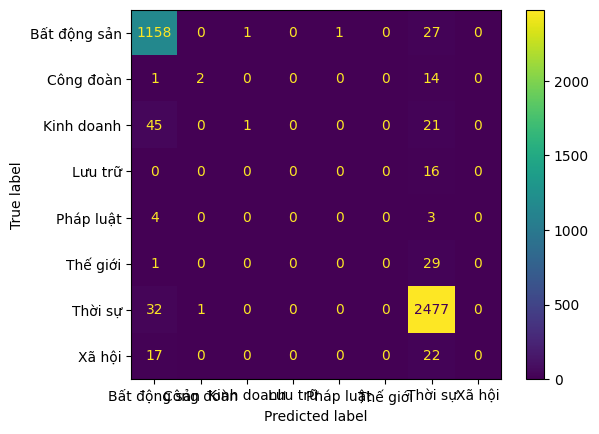

In [ ]:
# Khởi tạo và huấn luyện mô hình SVM
svm_model = SVC(kernel='linear', random_state=42)  # Sử dụng kernel 'linear' cho bài toán phân loại
svm_model.fit(X_train_tfidf, y_train)

# Đưa ra dự đoán trên tập kiểm tra
y_pred_svm = svm_model.predict(X_test_tfidf)

# Đánh giá mô hình
print("SVM Classifier:")
print(classification_report(y_test, y_pred_svm, zero_division=1))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:",precision_score(y_test, y_pred_svm, average='weighted'))
print("Recall:",recall_score(y_test, y_pred_svm, average='weighted'))
print("F1:",f1_score(y_test, y_pred_svm, average='weighted'))

ln_ps = round(m.precision_score(y_test,y_pred_svm,average='micro'), 4)
ln_rs = round(m.recall_score(y_test,y_pred_svm,average='micro'), 4)
ln_f1 = round(m.f1_score(y_test,y_pred_svm,average='micro'), 4)
print("micro: ", ln_ps, ln_rs, ln_f1)
# print(m.confusion_matrix(y_test, y_pred_svm))
print('Confusion display: ', ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm))

SVM Classifier:
              precision    recall  f1-score   support

Bất động sản       0.92      0.98      0.95      1187
   Công đoàn       0.50      0.06      0.11        17
  Kinh doanh       0.50      0.01      0.03        67
     Lưu trữ       0.00      0.00      0.00        16
   Pháp luật       0.00      0.00      0.00         7
    Thế giới       0.00      0.00      0.00        30
     Thời sự       0.95      0.99      0.97      2510
      Xã hội       0.00      0.00      0.00        39

    accuracy                           0.94      3873
   macro avg       0.36      0.25      0.26      3873
weighted avg       0.91      0.94      0.92      3873

Accuracy: 0.9393235218177124
micro:  0.9393 0.9393 0.9393


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion display:  <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x79d136eb7fd0>


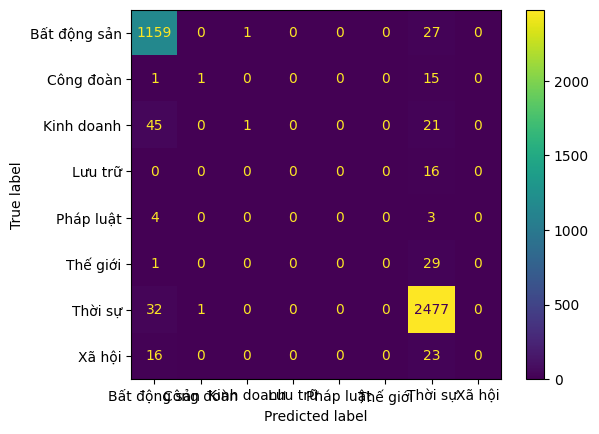

In [ ]:
# Khởi tạo và huấn luyện mô hình SVM với kernel sigmoid
svm_model = SVC(kernel='sigmoid')
svm_model.fit(X_train_tfidf, y_train)

# Đưa ra dự đoán trên tập kiểm tra
y_pred_sig = svm_model.predict(X_test_tfidf)

ln_ps = round(m.precision_score(y_test,y_pred_sig,average='micro'), 4)
ln_rs = round(m.recall_score(y_test,y_pred_sig,average='micro'), 4)
ln_f1 = round(m.f1_score(y_test,y_pred_sig,average='micro'), 4)

# Đánh giá mô hình
print("SVM Classifier:")
print(classification_report(y_test, y_pred_sig))
print("Accuracy:", accuracy_score(y_test, y_pred_sig))
print("micro: ", ln_ps, ln_rs, ln_f1)
print('Confusion display: ', ConfusionMatrixDisplay.from_predictions(y_test, y_pred_sig))

Table:
Metric | Linear SVM | Sigmoid SVM
----------------------------------------
Accuracy | 0.9393235218177124 | 0.9393235218177124
----------------------------------------
Precision | 0.9309284864820037 | 0.931776631809101
----------------------------------------
Recall | 0.9393235218177124 | 0.9393235218177124
----------------------------------------
F1-score | 0.9188769846605966 | 0.9184669032452776
----------------------------------------


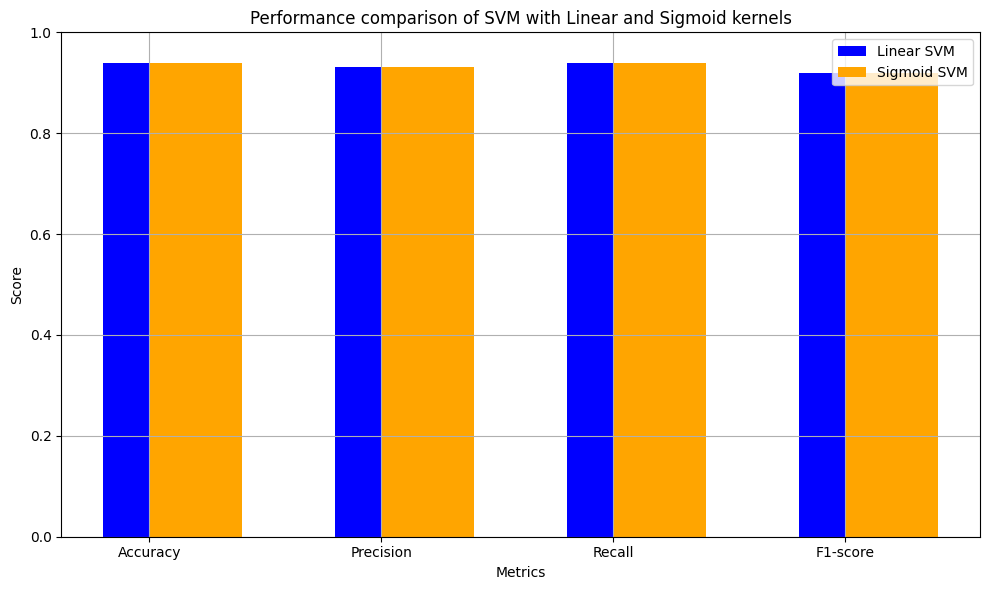

In [ ]:
# Tính toán các metric cho SVM kernel tuyến tính
accuracy_li = accuracy_score(y_test, y_pred_svm)
precision_li = precision_score(y_test, y_pred_svm, average='weighted', zero_division=1)
recall_li = recall_score(y_test, y_pred_svm, average='weighted', zero_division=1)
f1_li = f1_score(y_test, y_pred_svm, average='weighted', zero_division=1)

# Tính toán các metric cho SVM kernel sigmoid
accuracy_sig = accuracy_score(y_test, y_pred_sig)
precision_sig = precision_score(y_test, y_pred_sig, average='weighted', zero_division=1)
recall_sig = recall_score(y_test, y_pred_sig, average='weighted', zero_division=1)
f1_sig = f1_score(y_test, y_pred_sig, average='weighted', zero_division=1)

# Biểu đồ so sánh
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
svm_linear_metrics = [accuracy_li, precision_li, recall_li, f1_li]
svm_sigmoid_metrics = [accuracy_sig, precision_sig, recall_sig, f1_sig]

# Định dạng bảng
table = [
    ["Metric", "Linear SVM", "Sigmoid SVM"],
    ["Accuracy", accuracy_li, accuracy_sig],
    ["Precision", precision_li, precision_sig],
    ["Recall", recall_li, recall_sig],
    ["F1-score", f1_li, f1_sig]
]

# In bảng
print("Table:")
for row in table:
    print(" | ".join(map(str, row)))
    print("-" * 40)

plt.figure(figsize=(10, 6))

plt.bar(metrics, svm_linear_metrics, width=0.4, align='center', label='Linear SVM', color='blue')
plt.bar(metrics, svm_sigmoid_metrics, width=0.4, align='edge', label='Sigmoid SVM', color='orange')

plt.title('Performance comparison of SVM with Linear and Sigmoid kernels')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


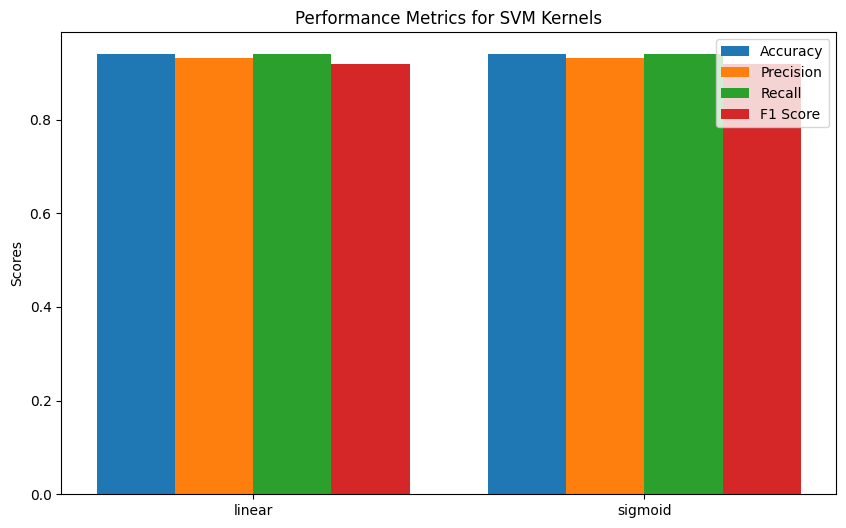

In [ ]:
# Tạo list chứa các giá trị metric
accuracy_scores = [accuracy_li, accuracy_sig]
precision_scores = [precision_li, precision_sig]
recall_scores = [recall_li,  recall_sig]
f1_scores = [f1_li,  f1_sig]

# Tạo list chứa các tên kernel
kernel_names = ['linear',  'sigmoid']

# Vẽ biểu đồ cột
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(np.arange(len(kernel_names)), accuracy_scores, width=0.2, label='Accuracy')
ax.bar(np.arange(len(kernel_names))+0.2, precision_scores, width=0.2, label='Precision')
ax.bar(np.arange(len(kernel_names))+0.4, recall_scores, width=0.2, label='Recall')
ax.bar(np.arange(len(kernel_names))+0.6, f1_scores, width=0.2, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Performance Metrics for SVM Kernels')
ax.set_xticks(np.arange(len(kernel_names))+0.3)
ax.set_xticklabels(kernel_names)
ax.legend()

plt.show()

## LogisticRegression

Logistic Regression Classifier:
              precision    recall  f1-score   support

Bất động sản       0.92      0.97      0.94      1187
   Công đoàn       0.50      0.06      0.11        17
  Kinh doanh       1.00      0.00      0.00        67
     Lưu trữ       0.00      0.00      0.00        16
   Pháp luật       1.00      0.00      0.00         7
    Thế giới       1.00      0.00      0.00        30
     Thời sự       0.94      0.99      0.96      2510
      Xã hội       1.00      0.00      0.00        39

    accuracy                           0.94      3873
   macro avg       0.80      0.25      0.25      3873
weighted avg       0.93      0.94      0.91      3873

Accuracy: 0.9351923573457268
Precision: 0.8953925354121974
Recall: 0.9351923573457268
F1 score: 0.9140466891058389


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion display:  <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x79d13c4d5900>


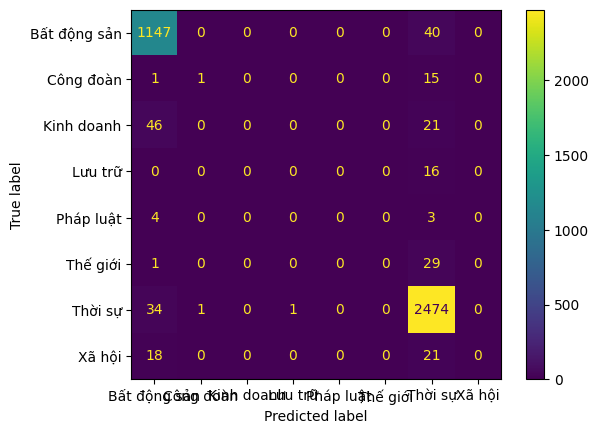

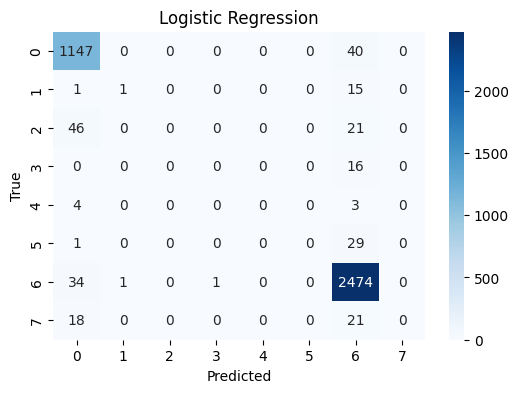

In [ ]:
# Khởi tạo và huấn luyện mô hình Logistic Regression
log_model = LogisticRegression(random_state=0)
log_model.fit(X_train_tfidf, y_train)

# Đưa ra dự đoán trên tập kiểm tra
y_pred_log = log_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred_log)

# Đánh giá mô hình
print("Logistic Regression Classifier:")
print(classification_report(y_test, y_pred_log,zero_division=1))

# tính toán các metric
accuracy = accuracy_score(y_test, y_pred_log)
precision = precision_score(y_test, y_pred_log, average='weighted')
recall = recall_score(y_test, y_pred_log, average='weighted')
f1 = f1_score(y_test, y_pred_log, average='weighted')

# in kết quả các metric
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")
print('Confusion display: ', ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log))

# vẽ heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression')
plt.show()

## Neural network

In [ ]:
# Chuẩn bị dữ liệu
encoder = LabelEncoder()
y_train_encoded = to_categorical(encoder.fit_transform(y_train))
y_test_encoded = to_categorical(encoder.transform(y_test))

# Xây dựng mô hình Sequential
model = Sequential([
    Dense(64, input_shape=(10000,), activation='relu'),
    # Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Số lượng lớp đầu ra là 10, phù hợp với số lượng danh mục
])

# Biên dịch mô hình
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

# Sau đó sử dụng X_train_tfidf_dense thay vì X_train_tfidf
model.fit(X_train_tfidf_dense, y_train_encoded, epochs=25, batch_size=32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
485/485 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7929 - loss: 0.8523
Epoch 2/25
485/485 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9416 - loss: 0.2913
Epoch 3/25
485/485 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9481 - loss: 0.2279
Epoch 4/25
485/485 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9484 - loss: 0.1974
Epoch 5/25
485/485 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9536 - loss: 0.1657
Epoch 6/25
485/485 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9528 - loss: 0.1472
Epoch 7/25
485/485 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9636 - loss: 0.1131
Epoch 8/25
485/485 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9602 - loss: 0.1082
Epoch 9/25
485/485 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9661 - loss: 0.0929
Epoch 10/25
485/485 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9706 - loss: 0.0792
Epoch 11/25
485/485 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9740 - loss: 0.0679
Epoch 12/25
485/485 ━━━━━━━━━━━━━━━━

In [ ]:
# Đánh giá mô hình trên tập kiểm tra
test_loss, test_acc = model.evaluate(X_test_tfidf_dense, y_test_encoded)
print('Test accuracy:', test_acc)

y_pred_decoded = model.predict(X_test_tfidf_dense)
y_pred_decoded = np.argmax(y_pred_decoded, axis=1)

# Chuyển đổi từ dạng One-Hot về nhãn số nguyên
y_test_int = np.argmax(y_test_encoded, axis=1)

# Đánh giá mô hình
print("Neural Network Classifier:")
print(classification_report(y_test_int, y_pred_decoded))


122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9287 - loss: 0.9836
Test accuracy: 0.9308030009269714
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Neural Network Classifier:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1187
           1       0.67      0.35      0.46        17
           2       0.23      0.10      0.14        67
           3       0.25      0.12      0.17        16
           4       0.00      0.00      0.00         7
           5       0.36      0.13      0.20        30
           6       0.95      0.97      0.96      2510
           7       0.00      0.00      0.00        39

    accuracy                           0.93      3873
   macro avg       0.42      0.33      0.36      3873
weighted avg       0.91      0.93      0.92      3873



# Đánh giá các mô hình

## Áp dụng Grid

In [ ]:
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'sigmoid']
}

svm_clf = SVC()

# Apply GridSearchCV for SVM
svm_grid_search = GridSearchCV(svm_clf, svm_param_grid, cv=5, scoring='accuracy', verbose=1)
svm_grid_search.fit(X_train_tfidf, y_train)

table = PrettyTable()

table.field_names = ["Algorithm", "Best Score", "Best Parameters"]
table.add_row(["SVM", svm_grid_search.best_score_, svm_grid_search.best_params_])

print(table)

# Get the best SVM model
best_svm_model = svm_grid_search.best_estimator_

# Evaluate the best SVM model on the test set
test_accuracy_svm = best_svm_model.score(X_test_tfidf, y_test)
print("Test Accuracy:", test_accuracy_svm)



Fitting 5 folds for each of 32 candidates, totalling 160 fits
+-----------+-------------------+------------------------------------------+
| Algorithm |     Best Score    |             Best Parameters              |
+-----------+-------------------+------------------------------------------+
|    SVM    | 0.941389369235708 | {'C': 1, 'gamma': 1, 'kernel': 'linear'} |
+-----------+-------------------+------------------------------------------+
Test Accuracy: 0.9393235218177124


## Grid LogisticRegression

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
lr = LogisticRegression(max_iter=1000)

grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train_tfidf, y_train)
print("Best Parameters:", grid_search.best_params_)

best_lr_model = grid_search.best_estimator_

test_accuracy_lr = best_lr_model.score(X_test_tfidf, y_test)
print("Test Accuracy:", test_accuracy_lr)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Test Accuracy: 0.9385489284792151


## Grid NN

In [ ]:
# Chuẩn bị dữ liệu
encoder = LabelEncoder()
y_train_encoded = to_categorical(encoder.fit_transform(y_train))
y_test_encoded = to_categorical(encoder.transform(y_test))

# Hàm xây dựng mô hình
def create_model(optimizer='adam', init='uniform', dropout_rate=0.5,):
    model = Sequential([
    Dense(64, input_shape=(10000,), activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Số lượng lớp đầu ra là 10, phù hợp với số lượng danh mục
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Tạo KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop'],
}

# Thực hiện GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_result = grid.fit(X_train_tfidf_dense, y_train_encoded)

# In kết quả tốt nhất
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# In tất cả kết quả
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Sử dụng mô hình tốt nhất để dự đoán
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test_tfidf_dense)

# Đánh giá mô hình
from sklearn.metrics import accuracy_score, classification_report
print("Test accuracy:", accuracy_score(y_test_encoded, y_pred))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model inst

Best: 0.938355 using {'batch_size': 64, 'epochs': 10, 'optimizer': 'adam'}
0.936419 (0.002181) with: {'batch_size': 32, 'epochs': 10, 'optimizer': 'adam'}
0.936096 (0.004436) with: {'batch_size': 32, 'epochs': 10, 'optimizer': 'rmsprop'}
0.934224 (0.004665) with: {'batch_size': 32, 'epochs': 20, 'optimizer': 'adam'}
0.932804 (0.004666) with: {'batch_size': 32, 'epochs': 20, 'optimizer': 'rmsprop'}
0.938355 (0.001705) with: {'batch_size': 64, 'epochs': 10, 'optimizer': 'adam'}
0.937645 (0.002361) with: {'batch_size': 64, 'epochs': 10, 'optimizer': 'rmsprop'}
0.935451 (0.002215) with: {'batch_size': 64, 'epochs': 20, 'optimizer': 'adam'}
0.935644 (0.002394) with: {'batch_size': 64, 'epochs': 20, 'optimizer': 'rmsprop'}
Test accuracy: 0.9362251484637232

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      1187
           1       0.00      0.00      0.00        17
           2       0.12      0.01      0.03        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# So sánh

In [ ]:
# Hàm đánh giá và trả về kết quả dạng dictionary
def evaluate_model(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

# Lưu trữ kết quả đánh giá của từng mô hình
results = []

# Đánh giá mô hình SVM
results.append(evaluate_model(y_test, y_pred_svm, "SVM"))

# Đánh giá mô hình Naive Bayes (giả sử bạn đã có kết quả y_pred_nb)
results.append(evaluate_model(y_test, y_pred_nb, "Naive Bayes"))

# Đánh giá mô hình Logistic Regression
results.append(evaluate_model(y_test, y_pred_log, "Logistic Regression"))

# Đánh giá mô hình Neural Network
# Chuyển đổi từ dạng One-Hot về nhãn số nguyên
y_test_int = np.argmax(y_test_encoded, axis=1)
results.append(evaluate_model(y_test_int, y_pred_decoded, "Neural Network"))

# Tạo bảng sử dụng PrettyTable
table = PrettyTable()
table.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"]

for result in results:
    table.add_row([result["Model"], round(result["Accuracy"], 4), round(result["Precision"], 4), round(result["Recall"], 4), round(result["F1 Score"], 4)])

# Hiển thị bảng kết quả
print(table)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


+---------------------+----------+-----------+--------+----------+
|        Model        | Accuracy | Precision | Recall | F1 Score |
+---------------------+----------+-----------+--------+----------+
|         SVM         |  0.9393  |   0.909   | 0.9393 |  0.9189  |
|     Naive Bayes     |  0.9277  |   0.886   | 0.9277 |  0.9063  |
| Logistic Regression |  0.9352  |   0.8954  | 0.9352 |  0.914   |
|    Neural Network   |  0.9308  |   0.9102  | 0.9308 |  0.9192  |
+---------------------+----------+-----------+--------+----------+


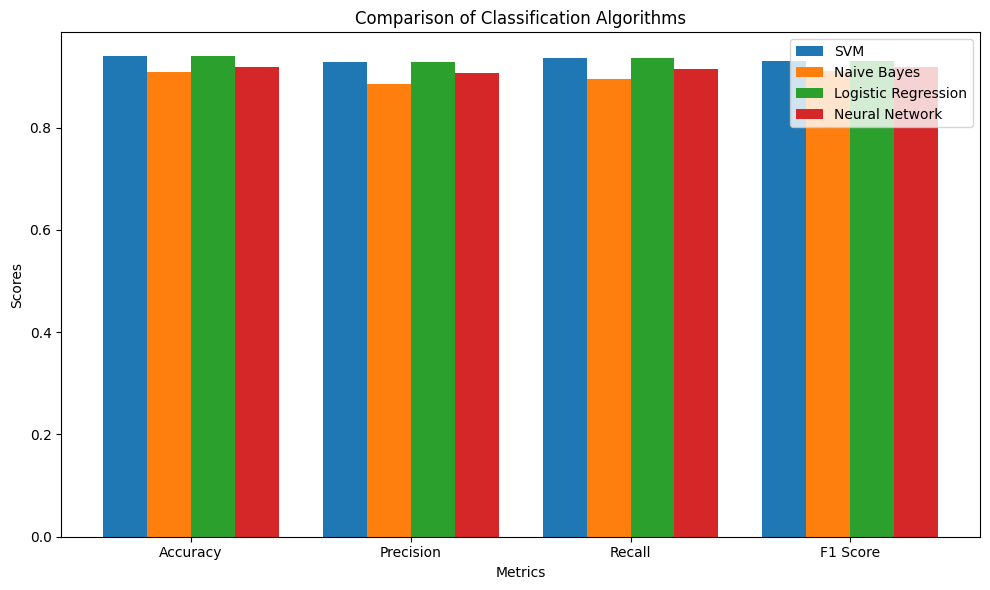

In [ ]:
# Tạo một danh sách các độ đo đánh giá
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]

# Tạo một danh sách các giá trị của các độ đo tương ứng cho các thuật toán
knn_scores = [result["Accuracy"] for result in results]
nb_scores = [result["Precision"] for result in results]
rf_scores = [result["Recall"] for result in results]
dt_scores = [result["F1 Score"] for result in results]

# Vẽ sơ đồ cột cho các giá trị đánh giá của các thuật toán
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.2

# Định vị các cột
x = np.arange(len(metrics))

# Vẽ các cột cho từng mô hình
ax.bar(x - width, knn_scores, width=width, label="SVM")
ax.bar(x, nb_scores, width=width, label="Naive Bayes")
ax.bar(x + width, rf_scores, width=width, label="Logistic Regression")
ax.bar(x + 2 * width, dt_scores, width=width, label="Neural Network")

# Thêm các chú thích và tên trục
ax.set_title("Comparison of Classification Algorithms")
ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_xticks(x + width / 2)
ax.set_xticklabels(metrics)
ax.legend()

# Hiển thị sơ đồ
plt.tight_layout()
plt.show()